In [1]:
import numpy as np
vmin = 0
vmax=1
levels=np.linspace(vmin,vmax,21)
import os
import sys
import re
import pandas as pd
import scipy
import csv
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
import seaborn.apionly as sns
from matplotlib import cm
import glob
import matplotlib
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = 1
import statistics
from scipy.stats import sem
from MiRMAK import utils
from MiRMAK.utils import normalise_between_2_values
from MiRMAK.utils import normalise_0_1
import matplotlib.colors as mcolors
tum_blue4_as_python_color = np.array([0, 82, 147]) / 255
cmap = sns.light_palette(tum_blue4_as_python_color, as_cmap=True)
beads = ["C0433","C0434","C0435"]
from matplotlib.colors import LinearSegmentedColormap
cmap1 = LinearSegmentedColormap.from_list("my_colormap", ((0, 0, 0), (1, 1, 1)), N=6, gamma=1.0)
cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1., 1), 
                                                          (1, 0, 0)],
                                                 N=len(levels)-1,
                                                 )
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import time
from scipy import interp
import pickle
from scipy.stats import ttest_ind
from pylab import *
import matplotlib.colors as colors
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
# import tlabtools as tools
from sklearn.externals import joblib

## functions
def create_colour_lists():
    '''
    Converts several lists of rgb colours to the python format (normalized to between 0 and 1)
    Returns a dictionary that contains dictionaries of palettes with named colours (eg. TUM blues)
    and also lists of unnamed colours (e.g. tableau20)
    (copied from tlabtools 2016.08.08)
    '''
    output_dict = {}

    matplotlib_150 = list(colors.cnames.values())
    output_dict['matplotlib_150'] = matplotlib_150

    #define colour dictionaries. TUM colours are based on the style guide.
    colour_dicts = {
                    'TUM_colours' : {
                                    'TUMBlue':(34,99,169),
                                    'TUM1':(100,160,200),
                                    'TUM2':(1,51,89),
                                    'TUM3':(42,110,177),
                                    'TUM4':(153,198,231),
                                    'TUM5':(0,82,147)
                                    },
                    'TUM_oranges': {
                        'TUM0': (202, 101, 10),
                        'TUM1': (213, 148, 96),
                        'TUM2': (102, 49, 5),
                        'TUM3': (220, 108, 11),
                        'TUM4': (247, 194, 148),
                        'TUM5': (160, 78, 8)
                    },
                    'TUM_accents' : {
                                    'green':(162,183,0),
                                    'orange':(227,114,34),
                                    'ivory':(218,215,203),
                                    }
                    }

    #convert the nested dicts to python 0 to 1 format
    for c_dict in colour_dicts:
        for c in colour_dicts[c_dict]:
            #define r, g, b as ints
            r, g, b = colour_dicts[c_dict][c]
            #normalise r, g, b and add to dict
            colour_dicts[c_dict][c] = (r / 255., g / 255., b / 255.)
        #add normalised colours to output dictionary
        output_dict[c_dict] = colour_dicts[c_dict]

    #define colour lists
    colour_lists = {
                    'tableau20' : [
                                 (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)
                                    ],
                    'tableau20blind' : [
                                         (0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
                                         (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
                                         (255, 188, 121), (207, 207, 207)
                                          ]
                    }
    #normalise the colours for the colour lists
    for rgb_list in colour_lists:
        colour_array = np.array(colour_lists[rgb_list])/255.
        colour_array_tup = tuple(map(tuple,colour_array))
        colour_lists[rgb_list] = colour_array_tup
        #add normalised colours to output dictionary
        output_dict[rgb_list] = colour_lists[rgb_list]
    #create a mixed blue/grey colour list, with greys in decreasing darkness
    TUM_colours_list_with_greys = []
    grey = 0.7
    for c in colour_dicts['TUM_colours'].values():
        TUM_colours_list_with_greys.append('%0.2f' % grey)
        TUM_colours_list_with_greys.append(c)
        grey -= 0.1
    output_dict['TUM_colours_list_with_greys'] = TUM_colours_list_with_greys

    output_dict['HTML_list01'] = ['#808080', '#D59460', '#005293', '#A1B11A', '#9ECEEC', '#0076B8', '#454545', "#7b3294", "#c2a5cf", "#008837", "#a6dba0"]
    return output_dict

def read_concat_wells(i,well,perc,df_out):
    df_file = r"Well_{}_Raw.csv".format(well)
    df = pd.read_csv(df_file, sep=';', decimal=',', skiprows=7,encoding="latin1")
#     create_contour_plot(well,perc,df)
#     create_diameter_pi_plot(well,perc,df)
    live_accuracy = 0
    dead_accuracy = 0
    live_accuracy, dead_accuracy = pi_accuracy(live_accuracy_list,dead_accuracy_list,well,perc,df)
    if i == 0:
        df["live"] = 1
    if i == 1:
        df["live"] = 0
    if df_out.empty:
        df_out = df
    else:
        df_out = pd.concat([df_out,df])
    return df_out, live_accuracy, dead_accuracy

def concat_df(df_all,df):
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
    return df_all

def pi_accuracy(live_accuracy_list,dead_accuracy_list,well,perc,df):
    df['PopID'] = df['PopID'].str.replace(',','.')
    df['PopID'] = df['PopID'].str.replace('#INF','000')
    df['PopID'] = df['PopID'].str.replace('#IND00','000')
    df['PopID'] = pd.to_numeric(df['PopID'])
    threshold = -1
    live_accuracy = 0
    dead_accuracy = 0
    if perc == "100":
        live_accuracy = df[df['PopID'] < threshold].shape[0]/df.shape[0]
    if perc == "0":
        dead_accuracy = df[df['PopID'] > threshold].shape[0]/df.shape[0]
    return live_accuracy, dead_accuracy
        

def create_diameter_pi_plot(well,perc,df):
    diameter_pi_png = r"D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae\Contour\{}{}_pi.png".format(perc,well)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    df['PopID'] = df['PopID'].str.replace(',','.')
    df['PopID'] = df['PopID'].str.replace('#INF','000')
    df['PopID'] = df['PopID'].str.replace('#IND00','000')
    df['Algendurchmesser [µm]'] = pd.to_numeric(df['Algendurchmesser [µm]'])
    df['PopID'] = pd.to_numeric(df['PopID'])
    df.plot(x='Algendurchmesser [µm]', y='PopID', style='o')
    fig.tight_layout()
    plt.savefig(diameter_pi_png)
    
def create_contour_plot(well,perc,df):
    df['PopID'] = df['PopID'].str.replace(',','.')
    df['PopID'] = df['PopID'].str.replace('#INF','000')
    df['PopID'] = df['PopID'].str.replace('#IND00','000')
    x=df['X_wellbezogen [nm]']
    y=df['Y_wellbezogen [nm]']
    z=np.array(df.PopID.astype(float) - df.PopID.astype(float).min())
    # z=np.array(df['relativer Ligandenwert'])
    xi = np.linspace(x.min()-1, x.max()+1, 500)
    yi = np.linspace(y.min()-1, y.max()+1, 500)
    zi = griddata(x, y, z, xi, yi, interp='linear')
    contour_png = r"D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae\Contour\{}{}.png".format(perc,well)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    vmin = 0
    vmax=1
    levels=np.linspace(vmin,vmax,6)
    # CS = plt.contourf(xi, yi, zi, levels=levels, cmap=cmap,vmin =vmin,vmax=vmax, alpha=0.5)
    CS = plt.contourf(xi, yi, zi)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2, 2))
    plt.xlabel('X (nm)')
    plt.ylabel('Y (nm)')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.text(0.8, 0.9, 'right top', transform=ax.transAxes)
    fig.colorbar(CS)
    plt.scatter(x,y,marker='o',c='black',s=0.5,alpha=0.8)
    fig.tight_layout()
    plt.savefig(contour_png)
    plt.show()    

C:\Users\zengb\Anaconda3\lib\site-packages\seaborn\apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
C:\Users\zengb\Anaconda3\lib\site-packages\libpysal\io\iohandlers\__init__.py:25: UserWarning: SQLAlchemy and Geomet not installed, database I/O disabled
  warnings.warn('SQLAlchemy and Geomet not installed, database I/O disabled')


In [2]:
import matplotlib.colors as colors
print(list(colors.cnames.values()))

['#F0F8FF', '#FAEBD7', '#00FFFF', '#7FFFD4', '#F0FFFF', '#F5F5DC', '#FFE4C4', '#000000', '#FFEBCD', '#0000FF', '#8A2BE2', '#A52A2A', '#DEB887', '#5F9EA0', '#7FFF00', '#D2691E', '#FF7F50', '#6495ED', '#FFF8DC', '#DC143C', '#00FFFF', '#00008B', '#008B8B', '#B8860B', '#A9A9A9', '#006400', '#A9A9A9', '#BDB76B', '#8B008B', '#556B2F', '#FF8C00', '#9932CC', '#8B0000', '#E9967A', '#8FBC8F', '#483D8B', '#2F4F4F', '#2F4F4F', '#00CED1', '#9400D3', '#FF1493', '#00BFFF', '#696969', '#696969', '#1E90FF', '#B22222', '#FFFAF0', '#228B22', '#FF00FF', '#DCDCDC', '#F8F8FF', '#FFD700', '#DAA520', '#808080', '#008000', '#ADFF2F', '#808080', '#F0FFF0', '#FF69B4', '#CD5C5C', '#4B0082', '#FFFFF0', '#F0E68C', '#E6E6FA', '#FFF0F5', '#7CFC00', '#FFFACD', '#ADD8E6', '#F08080', '#E0FFFF', '#FAFAD2', '#D3D3D3', '#90EE90', '#D3D3D3', '#FFB6C1', '#FFA07A', '#20B2AA', '#87CEFA', '#778899', '#778899', '#B0C4DE', '#FFFFE0', '#00FF00', '#32CD32', '#FAF0E6', '#FF00FF', '#800000', '#66CDAA', '#0000CD', '#BA55D3', '#9370DB'

## parameters
1. diameter in µm (called “Durchmesser”)
2. area in pixel (called “Gesamtfläche”)
3. form factor (called “Formfaktor”) a number describing the roundness of the particle = the ratio of the max. radius and the min. radius of the object
4. fluorescence signals 1 and 2 (called “Kodierung 1” und “Kodierung 2”), For all viability assays with VideoScan the Syto 9 staining should be signal 1 and PI should be signal 2
5. PopID = logarithmic ratio between the two fluorescence signals


## Positive and negative wells
1. Projekt006139-15-01-24-AB_RR_Algen_LebendTot  
    A1,B1,C1(positive,all living)  
    H5,A6,B6(negative,all dead)  
2. Projekt006141-16-01-2014-AB_RR_Algen_LebendTot  
    E6,F6,G6(positive,all living)  
    G8,H8,A9(negative,all dead)  

In [12]:
features = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad',
        'Kodierung1_Achteck',
       'Kodierung1_Hintergrund', 'Kodierung1_Achteck/Belichtungszeit-normiert',
       'Kodierung1_Achteck/Größen-Belichtungszeit-normiert',
       'Kodierung2_Achteck',
       'Kodierung2_Hintergrund', 'Kodierung2_Achteck/Belichtungszeit-normiert',
       'Kodierung2_Achteck/Größen-Belichtungszeit-normiert', 'PopID','live']
features1 = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad',
        'live']
features2 = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad']
features3 = ['Gesamtfläche [Pixel]', 'Algendurchmesser [µm]','Maximaler Radius [Pixel]','Minimaler Radius [Pixel]','Formfaktor MaxRad/MinRad',
        'Kodierung1_Achteck',
       'Kodierung1_Hintergrund', 'Kodierung1_Achteck/Belichtungszeit-normiert',
       'Kodierung1_Achteck/Größen-Belichtungszeit-normiert',
       'Kodierung2_Achteck',
       'Kodierung2_Hintergrund', 'Kodierung2_Achteck/Belichtungszeit-normiert',
       'Kodierung2_Achteck/Größen-Belichtungszeit-normiert', 'PopID']
dirs = [
       "D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae\Projekt006141-16-01-2014-AB_RR_Algen_LebendTot_Results",
       "D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae\Projekt006139-15-01-2014-AB_RR_Algen_LebendTot_Results"
       ]
pstv_wells_list = [["E6","F6","G6", "B9","C9","D9"],["A1","B1","C1", "F3","G3","H3"]]
ngtv_wells_list = [["G8","H8","A9","D11","E11","F11"],["C3","D3","E3","H5","A6","B6"]]
pec80_wells_list = [["H6","A7","B7","E9","F9","G9"],["D1","E1","F1","A4","B4","C4"]]
pec60_wells_list = [["C7","D7","E7","H9","A10","B10"],["G1","H1","A2","D4","E4","F4"]]
pec50_wells_list = [["F7","G7","H7","C10","D10","E10"],["B2","C2","D2","G4","H4","A5"]]
pec40_wells_list = [["A8","B8","C8","F10","G10","H10"],["E2","F2","G2","B5","C5","D5"]]
pec20_wells_list = [["D8","E8","F8","A11","B11","C11"],["H2","A3","B3","E5","F5","G5"]]
df_all_all = pd.DataFrame()
df_pstv_all = pd.DataFrame()
df_ngtv_all = pd.DataFrame()
df_80_all = pd.DataFrame()
df_60_all = pd.DataFrame()
df_50_all = pd.DataFrame()
df_40_all = pd.DataFrame()
df_20_all = pd.DataFrame()
df0 = pd.DataFrame()
live_accuracy_list = []
dead_accuracy_list = []
for i, dir in enumerate(dirs):
    os.chdir(dir)
    pstv_wells = pstv_wells_list[i]
    ngtv_wells = ngtv_wells_list[i]
    pec80_wells = pec80_wells_list[i]
    pec60_wells = pec60_wells_list[i]
    pec50_wells = pec50_wells_list[i]
    pec40_wells = pec40_wells_list[i]
    pec20_wells = pec20_wells_list[i]
    wells_list = [pstv_wells_list[i],ngtv_wells_list[i],pec80_wells_list[i],pec60_wells_list[i],pec50_wells_list[i]
            ,pec40_wells_list[i],pec20_wells_list[i]]
    perc_list = ["100","0","80","60","50","40","20"]
    df_pstv = pd.DataFrame()
    df_ngtv = pd.DataFrame()
    df_all = pd.DataFrame()
    df_80 = pd.DataFrame()
    df_60 = pd.DataFrame()
    df_50 = pd.DataFrame()
    df_40 = pd.DataFrame()
    df_20 = pd.DataFrame()
    df_out_list = [df_pstv,df_ngtv,df_80,df_60,df_50,df_40,df_20]
    for j,wells in enumerate(wells_list):
        for well in wells:
            df_out_list[j], live_accuracy, dead_accuracy = read_concat_wells(j,well,perc_list[j],df_out_list[j])
            live_accuracy_list.append(live_accuracy)
            dead_accuracy_list.append(dead_accuracy)
    df_pstv,df_ngtv,df_80,df_60,df_50,df_40,df_20 = df_out_list  
#     df_pstv = df_pstv[df_pstv.PopID < -1.0]
#     df_ngtv = df_ngtv[df_ngtv.PopID > -1.0]
    df_all = pd.concat([df_pstv,df_ngtv])
#     df_all['PopID'] = df_all['PopID'].str.replace(',','.')
#     df_all['PopID'] = df_all['PopID'].str.replace('#INF','000')
    df_all = df_all[features]
    df_pstv_all = concat_df(df_pstv_all,df_pstv)
    df_ngtv_all = concat_df(df_ngtv_all,df_ngtv)
    df_all_all = concat_df(df_all_all,df_all)
    df_80_all = concat_df(df_80_all,df_80)
    df_60_all = concat_df(df_60_all,df_60)
    df_50_all = concat_df(df_50_all,df_50)
    df_40_all = concat_df(df_40_all,df_40)
    df_20_all = concat_df(df_20_all,df_20)
#     df_pstv_all['PopID'] = df_pstv_all['PopID'].str.replace(',','.')
#     df_pstv_all['PopID'] = df_pstv_all['PopID'].str.replace('#INF','000')
#     df_pstv_all['PopID'] = df_pstv_all['PopID'].str.replace('#IND00','000')
#     df_ngtv_all['PopID'] = df_ngtv_all['PopID'].str.replace(',','.')
#     df_ngtv_all['PopID'] = df_ngtv_all['PopID'].str.replace('#INF','000')
#     df_ngtv_all['PopID'] = df_ngtv_all['PopID'].str.replace('#IND00','000')
#     df_80_all['PopID'] = df_80_all['PopID'].str.replace(',','.')
#     df_80_all['PopID'] = df_80_all['PopID'].str.replace('#INF','000')
#     df_80_all['PopID'] = df_80_all['PopID'].str.replace('#IND00','000')
#     df_60_all['PopID'] = df_60_all['PopID'].str.replace(',','.')
#     df_60_all['PopID'] = df_60_all['PopID'].str.replace('#INF','000')
#     df_60_all['PopID'] = df_60_all['PopID'].str.replace('#IND00','000')
#     df_50_all['PopID'] = df_50_all['PopID'].str.replace(',','.')
#     df_50_all['PopID'] = df_50_all['PopID'].str.replace('#INF','000')
#     df_50_all['PopID'] = df_50_all['PopID'].str.replace('#IND00','000')
#     df_40_all['PopID'] = df_40_all['PopID'].str.replace(',','.')
#     df_40_all['PopID'] = df_40_all['PopID'].str.replace('#INF','000')
#     df_40_all['PopID'] = df_40_all['PopID'].str.replace('#IND00','000')
#     df_20_all['PopID'] = df_20_all['PopID'].str.replace(',','.')
#     df_20_all['PopID'] = df_20_all['PopID'].str.replace('#INF','000')
#     df_20_all['PopID'] = df_20_all['PopID'].str.replace('#IND00','000')
    df_80_all,df_60_all,df_50_all,df_40_all,df_20_all = [df_80_all[features3],df_60_all[features3],df_50_all[features3]
                                                         ,df_40_all[features3],df_20_all[features3]]
os.chdir("D:\Ronny_Proj\Algae VideoScan raw data\live_dead_staining_defined_ratios_of_living_and_dead_algae")
print(df_all_all.shape)


C:\Users\zengb\Anaconda3\lib\site-packages\ipykernel_launcher.py:165: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



(90617, 15)


In [4]:
print(sum(live_accuracy_list)/12,sum(dead_accuracy_list)/12)

0.9505964704886622 0.9503008018631179


In [5]:
### compared 9 classifiers for live/dead algea classification
from sklearn.metrics import confusion_matrix
names = ["Nearest Neighbors", 
#          "Linear SVM", 
#          "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     SVC(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X = df_all_all.drop('live', 1)
y = df_all_all['live']
skf = StratifiedKFold(n_splits=10)
cv = list(skf.split(X, y))
n_features = X.shape[1]
for name, clf in zip(names, classifiers):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    accuracy_list = []
    recall_list =[]
    precision_list = []
    for i, (train, test) in enumerate(cv):
        sys.stdout.write("f{}.".format(i + 1)), sys.stdout.flush()
        probas_ = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        binaris_ = clf.fit(X.iloc[train], y.iloc[train]).predict(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1], drop_intermediate=False)
        tn, fp, fn, tp = confusion_matrix(y.iloc[test], binaris_).ravel()
        accuracy = (tn+tp)/(tn+fp+fn+tp)
        print(tp,tn,fp,fn)
        accuracy_list.append(accuracy)
        recall = tp/(fn+tp)
        precision = tp/(fp+tp)
        recall_list.append(recall)
        precision_list.append(precision)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    mean_acc = mean(accuracy_list)
    mean_precision = mean(precision_list)
    mean_recall = mean(recall_list)
    sys.stdout.write('{} 10-fold validation. AUC({:.3f}). mean accuracy :{}. \n mean precision {}. mean recall {}'.format(name, mean_auc,mean_acc,mean_precision,mean_recall))


f1.3028 2670 1152 1757
f2.3130 2601 1221 1655
f3.3988 2544 1278 797
f4.4051 2683 1139 734
f5.4302 2755 1067 483
f6.3712 2861 961 1072
f7.3570 2685 1137 1214
f8.3676 2974 848 1108
f9.3714 2553 1268 1070
f10.3783 2720 1101 1001
Nearest Neighbors 10-fold validation. AUC(0.795). mean accuracy :0.7436415864587813. 
 mean precision 0.7668298271881494. mean recall 0.7723690209091258f1.3087 2753 1069 1698
f2.3195 2738 1084 1590
f3.4150 2631 1191 635
f4.4425 2608 1214 360
f5.4424 2928 894 361
f6.3929 2986 836 855
f7.3680 2862 960 1104
f8.3847 3130 692 937
f9.3834 2676 1145 950
f10.3983 2842 979 801
Decision Tree 10-fold validation. AUC(0.851). mean accuracy :0.7751071656883608. 
 mean precision 0.7921000311907671. mean recall 0.8058104208385318f1.3193 2702 1120 1592
f2.3164 2785 1037 1621
f3.4130 2697 1125 655
f4.4399 2628 1194 386
f5.4393 2938 884 392
f6.3896 3032 790 888
f7.3566 2928 894 1218
f8.3819 3162 660 965
f9.3811 2683 1138 973
f10.3951 2849 972 833
Random Forest 10-fold validation. AU

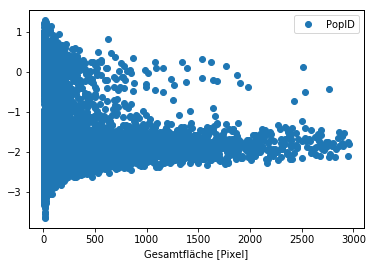

In [7]:
df_pstv_all['Gesamtfläche [Pixel]'] = pd.to_numeric(df_pstv_all['Gesamtfläche [Pixel]'])
df_pstv_all['PopID'] = pd.to_numeric(df_pstv_all['PopID'])
df_pstv_all.plot(x='Gesamtfläche [Pixel]', y='PopID', style='o')

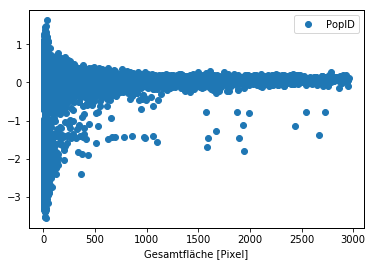

In [8]:
df_ngtv_all['Gesamtfläche [Pixel]'] = pd.to_numeric(df_ngtv_all['Gesamtfläche [Pixel]'])
df_ngtv_all['PopID'] = pd.to_numeric(df_ngtv_all['PopID'])
df_ngtv_all.plot(x='Gesamtfläche [Pixel]', y='PopID', style='o')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000233B48130F0>]],
      dtype=object)

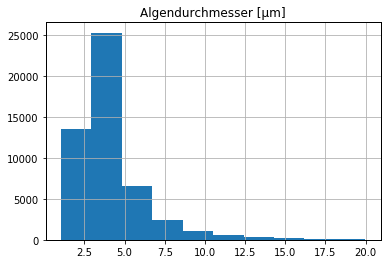

In [20]:
# df_80_all["Algendurchmesser [µm]"].plot(type="bar")
df_pstv_all.hist(column='Algendurchmesser [µm]')

In [16]:
df_list = [df_80_all,df_60_all,df_50_all,df_40_all,df_20_all]
ratio = df_80_all[df_80_all<-1.0].shape[0] / df_80_all.shape[0]
ratio


1.0